In [1]:
from tdc.multi_pred import DrugRes
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import shutil 
import pickle
import networkx as nx

from scripts.data_loader import DataDownloader
from scripts.preprocessor import Preprocessor

### **Getting to Know Our Data**  

In [2]:
downloader = DataDownloader()  # Create an instance of DataDownloader
data, gdsc_df, gdsc_gene = downloader.fetch_gdsc1_dataset()

Downloading...


100%|████████████████████| 140M/140M [07:40<00:00, 305kiB/s]
Loading...
Done!
Downloading...
100%|████████████████████| 149k/149k [00:00<00:00, 224kiB/s]
Loading...


Dataset successfully moved to /home/gentroyal/outreachy-contributions/data


#### Some Useful Methods  

Some methods gotten from running help(data), the`data` documentation that may be useful later:  
- **`get_split()`** – Splits the dataset into train, validation, and test sets.
- **`print_stats()`** to print the statistics of the dataset
- **`to_graph()`** - to get key information in the dataset


This will be updated as needed

In [3]:
data.print_stats() #Exploring print_stats()

--- Dataset Statistics ---
208 unique drugs.
958 unique cell lines.
177310 drug-cell line pairs.
--------------------------


The dataset label consists of affinity scores. Binarization using threshold 0.7 is conducted to construct the positive edges in the network. Adjust the threshold by to_graph(threshold = X)


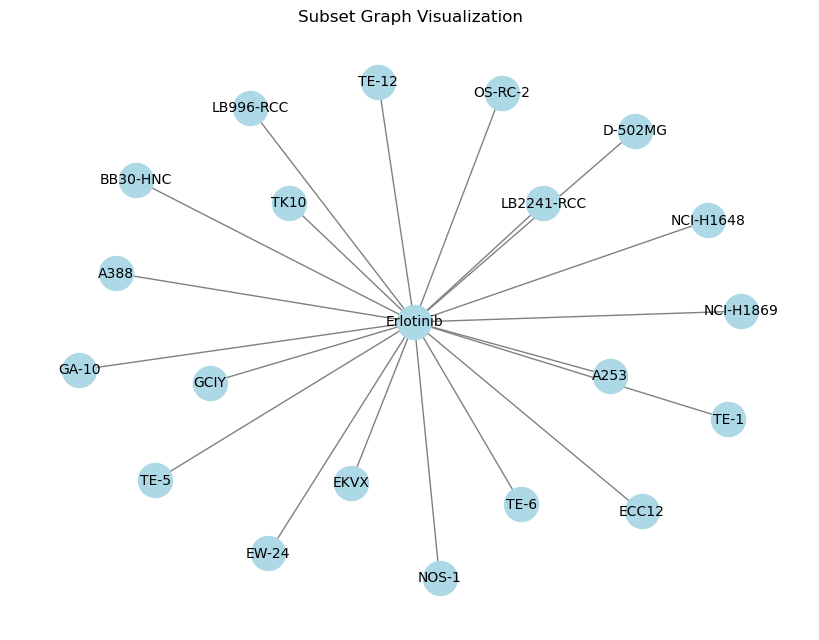

In [4]:
# Exploring to_graph()

graph_data = data.to_graph(threshold=0.7, format="edge_list", split=True)
edge_list = graph_data.get("edge_list", [])  # This ensures that key exists

edge_subset = edge_list[:20]  # To make our visual not look clumpsy, we select just a subset

G = nx.Graph()
G.add_edges_from(edge_subset)

pos = nx.spring_layout(G, seed=42)  # Ensures better node spacing

plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=600, font_size=10)
plt.title("Subset Graph Visualization")
plt.show();

**Comment:** The drug `Erlotinib` shows strong interactions with multiple cancer cell lines (TE-12, OS-RC-2, D-502MG, etc). This means that that these cell lines may be highly sensitive to the drug. At a first glance, we can say that `Erlotinib` reduces the survival rates of these cell lines but this is subjected to further analysis

#### **Explore the DataFrames**  

The `.pkl` file in the dataset is a DataFrame. We want to compare it with the DataFrame from `data.get_data()` to check if they are the same.  

In [5]:
gdsc_df.head()

,Drug_ID,Drug,Cell Line_ID,Cell Line,Y
0,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,MC-CAR,"[3.23827250519154, 2.98225419469807, 10.235490...",2.395685
1,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,ES3,"[8.690197905033282, 3.0914731119366, 9.9924871...",3.140923
2,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,ES5,"[8.233101127037282, 2.82468731112752, 10.01588...",3.968757
3,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,ES7,"[8.33346622426757, 3.9667571228514302, 9.79399...",2.692768
4,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,EW-11,"[8.39134072442845, 2.9683601858810698, 10.2606...",2.478678


In [6]:
benchmark_df = downloader.load_benchmark()
benchmark_df.head()

Dataset successfully loaded from /home/gentroyal/outreachy-contributions/data/gdsc1.pkl


,ID1,ID2,X1,X2,Y
0,Erlotinib,MC-CAR,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,"[3.23827250519154, 2.98225419469807, 10.235490...",2.395685
1,Erlotinib,ES3,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,"[8.690197905033282, 3.0914731119366, 9.9924871...",3.140923
2,Erlotinib,ES5,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,"[8.233101127037282, 2.82468731112752, 10.01588...",3.968757
3,Erlotinib,ES7,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,"[8.33346622426757, 3.9667571228514302, 9.79399...",2.692768
4,Erlotinib,EW-11,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,"[8.39134072442845, 2.9683601858810698, 10.2606...",2.478678


In [7]:
preprocessor = Preprocessor(gdsc_df, benchmark_df)
preprocessor.compare_dataframes()

Preprocessing completed successfully.
Comparing DataFrames...


'Both DataFrames are the same.'

**Comment:** Since they are the same, we can load the .pkl file instead of re-downloading the dataset each time

In [8]:
gdsc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177310 entries, 0 to 177309
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Drug_ID       177310 non-null  object 
 1   Drug          177310 non-null  object 
 2   Cell Line_ID  177310 non-null  object 
 3   Cell Line     177310 non-null  object 
 4   Y             177310 non-null  float64
dtypes: float64(1), object(4)
memory usage: 6.8+ MB


In [9]:
gdsc_gene.head()

,GENE_SYMBOLS
0,TSPAN6
1,TNMD
2,DPM1
3,SCYL3
4,C1orf112


In [10]:
gdsc_gene.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17737 entries, 0 to 17736
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   GENE_SYMBOLS  17419 non-null  object
dtypes: object(1)
memory usage: 138.7+ KB


**Comment:** This dataset has some null entries

In [11]:
gdsc_gene.GENE_SYMBOLS.nunique()

17419

**Comment:** There are no unique gene symbols (We got 17419 non null objects from **`.info()`** method). So, each of the the 17737 entries represent a unique gene

In [12]:
print(f"Unique Drug_IDs: {gdsc_df['Drug_ID'].nunique()}, Unique Drug Names: {gdsc_df['Drug'].nunique()}")

Unique Drug_IDs: 208, Unique Drug Names: 208


In [13]:
print(f"Unique Cell Line IDs: {gdsc_df['Cell Line_ID'].nunique()}, Unique Cell Line Names: {gdsc_df['Cell Line'].astype(str).nunique()}")

Unique Cell Line IDs: 958, Unique Cell Line Names: 958


In [14]:
print(f"Number of Drug 'Cell Line' pair: {len(gdsc_df['Cell Line'].loc[0])}")

Number of Drug 'Cell Line' pair: 17737


**Comment:** The above results correspond to the dataset statistics we got earlier

#### More EDA's

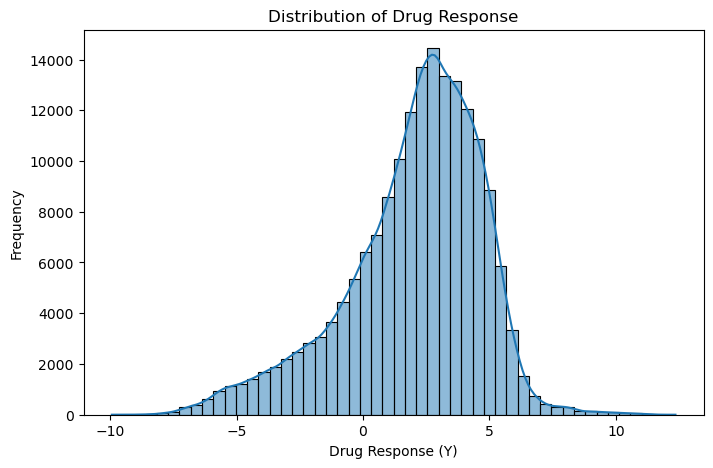

In [15]:
plt.figure(figsize=(8, 5))
sns.histplot(gdsc_df['Y'], bins=50, kde=True)
plt.xlabel("Drug Response (Y)")
plt.ylabel("Frequency")
plt.title("Distribution of Drug Response")
plt.show()

**Comment:** The histogram represents the distribution of drug response values (Y) across the cell lines. The distribution is approximately normal but is slightly skewed to the right. This means that that most cell lines show moderate responses to drug, centered around 2, although  some have higher responses, represented by the extended tail to the right.

In [16]:
# Get the top 10 most common Drug_IDs
top_drugs = gdsc_df['Drug_ID'].value_counts().head(10)
top_drugs

Drug_ID
PLX-4720       1837
Afatinib       1824
Avagacestat    1823
Olaparib       1819
UNC0638        1803
Pictilisib     1786
Selumetinib    1781
Refametinib    1772
AZD6482        1762
JQ1            1760
Name: count, dtype: int64

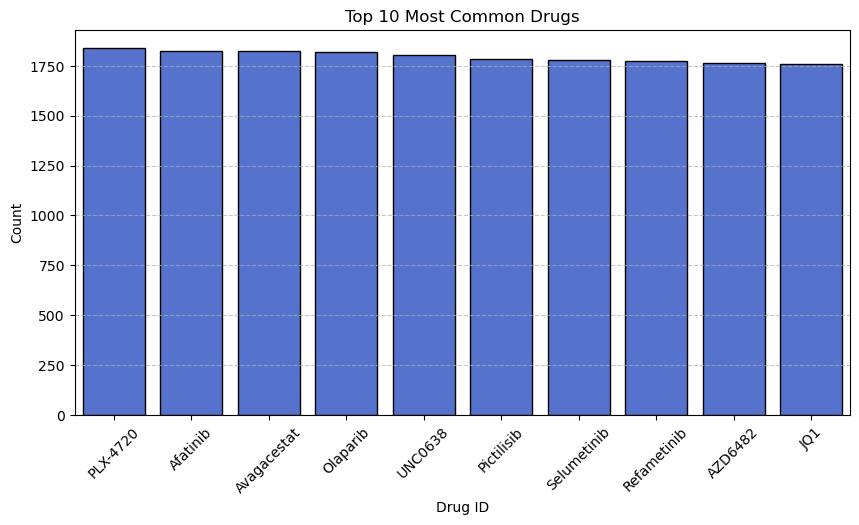

In [17]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = top_drugs.index, y = top_drugs.values, color = "royalblue", edgecolor ='black')

plt.xlabel("Drug ID")
plt.ylabel("Count")
plt.title("Top 10 Most Common Drugs")
plt.xticks(rotation=45)
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)

plt.show()

**Comment:** The most common drug in the dataset is PLX-4720 with a total of 1,837 occurrences and it is closely followed by Afatinib (1,824) and Avagacestat (1,823).

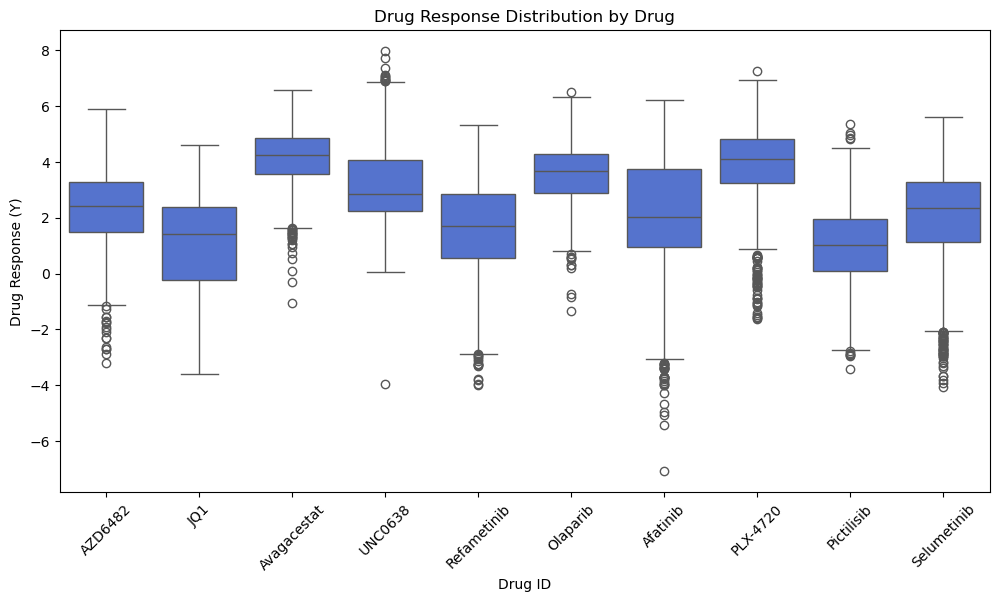

In [18]:
plt.figure(figsize=(12, 6))
top_drugs = gdsc_df['Drug_ID'].value_counts().index[:10]  # Select top 10 most frequent drugs
sns.boxplot(x = 'Drug_ID', y = 'Y', data = gdsc_df[gdsc_df['Drug_ID'].isin(top_drugs)], color = 'royalblue')
plt.xticks(rotation = 45)
plt.xlabel("Drug ID")
plt.ylabel("Drug Response (Y)")
plt.title("Drug Response Distribution by Drug")
plt.show()

**Comment:** The box plot compares the drug response (Y) distributions for the top 10 drugs. Most drugs have median responses between 1 and 3, meaning that they have moderate effectiveness. Drugs like Afatinib and Selumetinib, show higher variability with extreme negative outliers. Avagacestat and Olaparib show relatively higher and more stable responses, meaning they have better consistency across cell lines. 

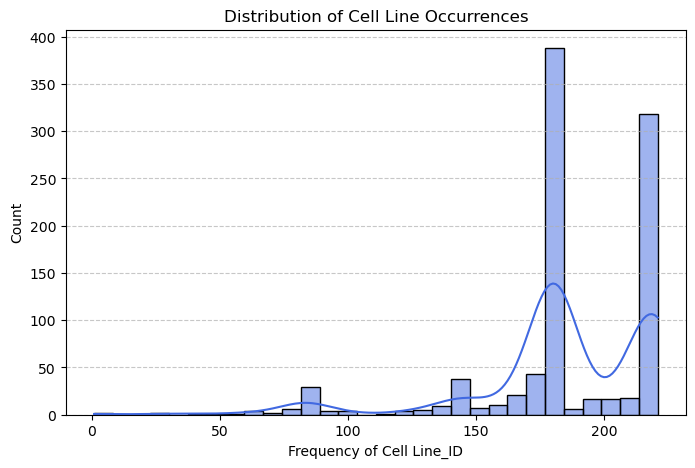

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(gdsc_df['Cell Line_ID'].value_counts().values, bins=30, kde=True, color='royalblue')

# Labels and Title
plt.xlabel("Frequency of Cell Line_ID")
plt.ylabel("Count")
plt.title("Distribution of Cell Line Occurrences")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

**Comment:** The histogram shows the distribution of cell line occurrences, showing that some cell lines appear significantly more often than others. There are peaks around 180 and 220 and this shows that specific cell lines are heavily represented in the dataset. The long tail towards lower frequencies means that many cell lines appear less often.

**Additional Comment:**  Up to this point, I've been using the dataset gotten from data.get_data() because it returns not only the csv file but also some useful methods (like get_split(), print_stats(), to_graph(), etc), all of which I have explored.
The csv file has been saved in the `data\` folder
Moving forward, I'll load my dataset from the `data\` folder. So that I can start running this notebook from this point, next time I want to work with it.

### **Featurizer**  